# Measuring the water level of Munich area


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [104]:
# Set and check config.
from sentinelhub import SHConfig

# In case you put the credentials into the configuration file you can leave this unchanged
#!Please using your ID and SECRET
CLIENT_ID = '92bd4c16-ad66-4aa5-8034-88f5a8c56f4b'
CLIENT_SECRET = 'e^&rE#u&530jK^7WT|d)_)}[NX%tt5FvSng<EV])'

# Input config.
config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")

## Imports

### eo-learn imports

In [2]:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, Dependency, FeatureType

# We'll use Sentinel-2 imagery (Level-1C) provided through Sentinel Hub
# If you don't know what `Level 1C` means, don't worry. It doesn't matter.

from eolearn.io.processing_api import SentinelHubInputTask
from eolearn.core import LoadFromDisk, SaveToDisk

from eolearn.mask import AddValidDataMaskTask

# filtering of scenes
from eolearn.features import SimpleFilterTask, NormalizedDifferenceIndexTask

# burning the vectorised polygon to raster
from eolearn.geometry import VectorToRaster

### Other imports 

In [3]:
# The golden standard: numpy and matplotlib
import numpy as np

# import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For manipulating geo-spatial vector dataset (polygons of nominal water extent)
import geopandas as gpd

# Image manipulations
# Our water detector is going to be based on a simple threshold 
# of Normalised Difference Water Index (NDWI) grayscale image
from skimage.filters import threshold_otsu

# Loading polygon of nominal water extent
import shapely.wkt
from shapely.geometry import Polygon

# sentinelhub-py package
from sentinelhub import BBox, CRS, DataCollection

## Water level extraction EOWorkflow

Our basic logic of the example workflow is:

1. Download all available Sentinel-2 sattelite imagery of Theewaterskloof Dam from beginning of 2016 and today
    * We want to calculate NDWI and also have a true color visualization of the area. We need the following bands: 
        * B02, B03, B04 for `TRUE_COLOR` for visualisations
        * B03, B08 for NDWI calculation 
        * CLM (provided by Sentinel Hub) for cloud masking
2. Clouds are very often obscuring the view of the ground. In order to correctly determine the water level of the dam all images with clouds need to be filtered out. We will use the cloud masks provided by Sentinel Hub to filter clouds without the need for time consuming processing locally.
3. Apply adaptive thresholding to `NDWI` grayscale images
4. Extract water level from a comparison of measured water extent with the nominal one

Each step in the above overview of the workflow is accomplished by adding an `EOTask` to the `EOWorkflow`

#### Load the Polygon of nominal water extent and define a BBOX

The BBOX defines an area of interest and will be used to create an EOPatch.

Dimension of the area is 1303102788 m2


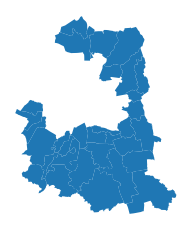

In [64]:
INPUT_FILE = './munich.geojson'
#!TODO: this area of munich is not right. but I don't know how to calculate.
# Load geojson file
munich = gpd.read_file(INPUT_FILE)
munich_crs = munich.to_crs("EPSG:32633")

# Plot munich bbox
munich.plot()
plt.axis('off');

# Print size 
_area = 0
for state in munich_crs.geometry.values:
    state_area = (state.bounds[2] - state.bounds[0]) * (state.bounds[3] - state.bounds[1])
    _area += state_area
print('Dimension of the area is {0:.0f} m2'.format(_area))

garching = munich.loc[16]

In [85]:
def inflate_bbox(original_bbox: BBox, inflate_rate = 0.1) -> BBox:
    """TODO add comments"""
    # inflate the BBOX 
    inflate_bbox = inflate_rate
    minx, miny, maxx, maxy = original_bbox.bounds

    delx = maxx - minx
    dely = maxy - miny
    minx = minx - delx * inflate_bbox
    maxx = maxx + delx * inflate_bbox
    miny = miny - dely * inflate_bbox
    maxy = maxy + dely * inflate_bbox
        
    inflate_bbox = BBox([minx, miny, maxx, maxy], crs=CRS.WGS84)
    
    
    return inflate_bbox, inflate_bbox.geometry - original_bbox

#inflate garching area
garching_bbox, inflate_garching = inflate_bbox(garching.geometry)

### Step 1: Intialize (and implement workflow specific) EOTasks

#### Create an EOPatch and add all EO features (satellite imagery data)

In [66]:
download_task = SentinelHubInputTask(data_collection=DataCollection.SENTINEL2_L1C, 
                                     bands_feature=(FeatureType.DATA, 'BANDS'),
                                     resolution=20, 
                                     maxcc=0.5, 
                                     bands=['B02', 'B03', 'B04', 'B08'], 
                                     additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'), (FeatureType.MASK, 'CLM')]
                                    )

calculate_ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDWI'), (1, 3))

#### Burn in the nominal water extent

The `VectorToRaster` task expects the vectorised dataset in geopandas dataframe.

In [67]:
garching_gdf = gpd.GeoDataFrame(crs=CRS.WGS84.pyproj_crs(), geometry=[garching.geometry])

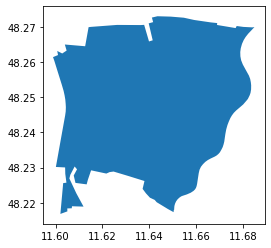

In [68]:
garching_gdf.plot();

In [69]:
add_nominal_water = VectorToRaster(garching_gdf, (FeatureType.MASK_TIMELESS, 'NOMINAL_WATER'), values=1, 
                                   raster_shape=(FeatureType.MASK, 'IS_DATA'), raster_dtype=np.uint8)

In [70]:
garching_gdf.geometry

0    POLYGON ((11.66893 48.27057, 11.67689 48.26969...
Name: geometry, dtype: geometry

#### The cloud mask is already provided by Sentinel Hub, we use it to calulcate the valid data mask. 

Define a `VALID_DATA` layer: pixel has to contain data and should be classified as clear sky by the cloud detector (`CLM` equals 0)

In [71]:
def calculate_valid_data_mask(eopatch):
    is_data_mask = eopatch.mask['IS_DATA'].astype(np.bool)
    cloud_mask = ~eopatch.mask['CLM'].astype(np.bool)
    return np.logical_and(is_data_mask, cloud_mask)

add_valid_mask = AddValidDataMaskTask(predicate=calculate_valid_data_mask)

Calculate fraction of valid pixels per frame and store it as `SCALAR` feature

In [72]:
def calculate_coverage(array):
    return 1.0 - np.count_nonzero(array) / np.size(array)

class AddValidDataCoverage(EOTask):
    
    def execute(self, eopatch):
        
        valid_data = eopatch.get_feature(FeatureType.MASK, 'VALID_DATA')
        time, height, width, channels = valid_data.shape
        
        coverage = np.apply_along_axis(calculate_coverage, 1,
                                       valid_data.reshape((time, height * width * channels)))
        
        eopatch.add_feature(FeatureType.SCALAR, 'COVERAGE', coverage[:, np.newaxis])
        return eopatch
    
add_coverage = AddValidDataCoverage()

Filter out too cloudy scenes. We filter out all observation which have cloud coverage of more than 5%. 


In [73]:
cloud_coverage_threshold = 0.05 

class ValidDataCoveragePredicate:
    
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        return calculate_coverage(array) < self.threshold
    
remove_cloudy_scenes = SimpleFilterTask((FeatureType.MASK, 'VALID_DATA'),
                                        ValidDataCoveragePredicate(cloud_coverage_threshold))

#### Apply Water Detection



In [74]:
class WaterDetector(EOTask):
    
    @staticmethod
    def detect_water(ndwi):
        """
        Very simple water detector based on Otsu thresholding method of NDWI.
        """
        otsu_thr = 1.0
        if len(np.unique(ndwi)) > 1:
            ndwi[np.isnan(ndwi)] = -1
            otsu_thr = threshold_otsu(ndwi)

        return ndwi > otsu_thr

    def execute(self, eopatch):
        water_masks = np.asarray([self.detect_water(ndwi[...,0]) for ndwi in eopatch.data['NDWI']])
        
        # we're only interested in the water within the dam borders
        water_masks = water_masks[...,np.newaxis] * eopatch.mask_timeless['NOMINAL_WATER']
        
        water_levels = np.asarray([np.count_nonzero(mask)/np.count_nonzero(eopatch.mask_timeless['NOMINAL_WATER']) 
                                   for mask in water_masks])
        
        eopatch.add_feature(FeatureType.MASK, 'WATER_MASK', water_masks)
        eopatch.add_feature(FeatureType.SCALAR, 'WATER_LEVEL', water_levels[...,np.newaxis])
        
        return eopatch
    
water_detection = WaterDetector()

### Step 2: Define the EOWorkflow

In [75]:
workflow = LinearWorkflow(download_task, calculate_ndwi, add_nominal_water, add_valid_mask,
                          add_coverage, remove_cloudy_scenes, water_detection)

### Step 3: Run the workflow

Process all Sentinel-2 acquisitions from beginning of 2016 and until beginning of June 2020.

In [76]:
time_interval = ['2019-01-01','2020-06-01']

In [77]:
result = workflow.execute({
    download_task: {
        'bbox': garching_bbox,
        'time_interval': time_interval
    },
})

In [78]:
patch = list(result.values())[-1]

Print content of eopatch at the end of the workflow execution

# Plot results

In [79]:
from skimage.filters import sobel
from skimage.morphology import disk
from skimage.morphology import erosion, dilation, opening, closing, white_tophat

In [80]:
def plot_rgb_w_water(eopatch, idx):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x) / np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    fig, ax = plt.subplots(figsize=(ratio * 10, 10))
    
    ax.imshow(2.5*eopatch.data['BANDS'][..., [2, 1, 0]][idx])
    
    observed = closing(eopatch.mask['WATER_MASK'][idx,...,0], disk(1))
    nominal = sobel(eopatch.mask_timeless['NOMINAL_WATER'][...,0])
    observed = sobel(observed)
    nominal = np.ma.masked_where(nominal == False, nominal)
    observed = np.ma.masked_where(observed == False, observed)
    
    ax.imshow(nominal, cmap=plt.cm.Reds)
    ax.imshow(observed, cmap=plt.cm.Blues)
    ax.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


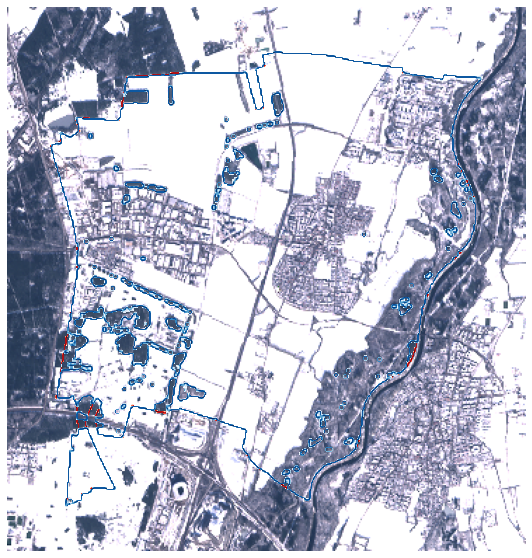

In [81]:
plot_rgb_w_water(patch, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


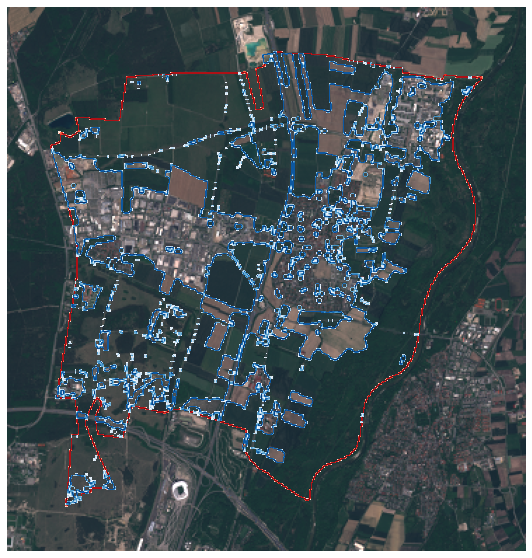

In [82]:
plot_rgb_w_water(patch, -1)

In [83]:
def plot_water_levels(eopatch, max_coverage=1.0):
    fig, ax = plt.subplots(figsize=(20, 7))

    dates = np.asarray(eopatch.timestamp)
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0] < max_coverage],
            eopatch.scalar['WATER_LEVEL'][eopatch.scalar['COVERAGE'][...,0] < max_coverage],
            'bo-', alpha=0.7)
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0] < max_coverage],
            eopatch.scalar['COVERAGE'][eopatch.scalar['COVERAGE'][...,0] < max_coverage],
            '--', color='gray', alpha=0.7)
    ax.set_ylim(0.0, 1.1)
    ax.set_xlabel('Date')
    ax.set_ylabel('Water level')
    ax.set_title('Water Levels')
    ax.grid(axis='y')
    return ax

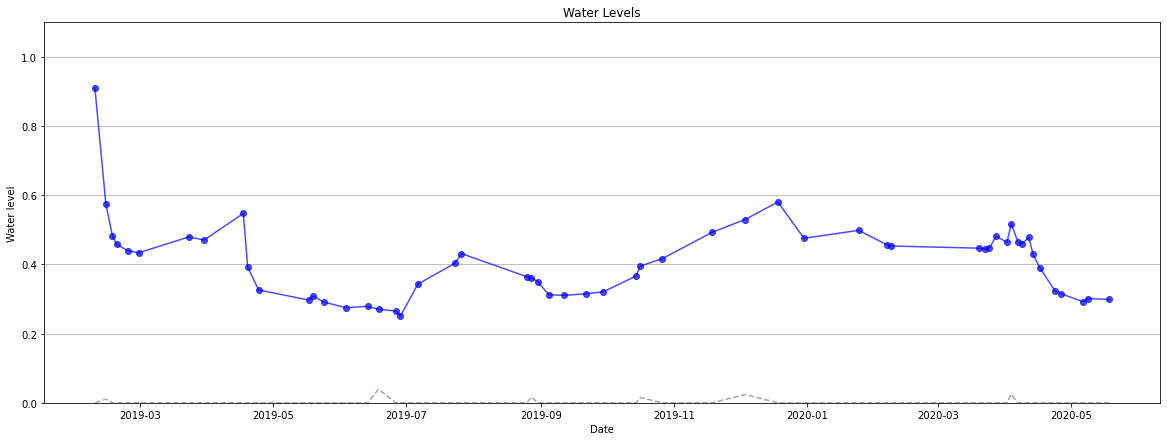

In [84]:
ax = plot_water_levels(patch, 1.0)